In [5]:
import torch
import os
import os.path as osp
from math import pi as PI
from math import sqrt
from typing import Callable

In [377]:
class Envelope(torch.nn.Module):
    def __init__(self, exponent):
        super().__init__()
        self.p = exponent + 1
        self.a = -(self.p + 1) * (self.p + 2) / 2
        self.b = self.p * (self.p + 2)
        self.c = -self.p * (self.p + 1) / 2

    def forward(self, x):
        p, a, b, c = self.p, self.a, self.b, self.c
        x_pow_p0 = x.pow(p - 1)
        x_pow_p1 = x_pow_p0 * x
        x_pow_p2 = x_pow_p1 * x
        return 1. / x + a * x_pow_p0 + b * x_pow_p1 + c * x_pow_p2
    
class BesselBasisLayer(torch.nn.Module):
    def __init__(self, num_radial, cutoff=5.0, envelope_exponent=5):
        super().__init__()
        self.cutoff = cutoff
        self.envelope = Envelope(envelope_exponent)

        self.freq = torch.nn.Parameter(torch.Tensor(num_radial))

        self.reset_parameters()

    def reset_parameters(self):
        torch.arange(1, self.freq.numel() + 1, out=self.freq).mul_(PI)

    def forward(self, dist):
        dist = dist.unsqueeze(-1) / self.cutoff
        return self.envelope(dist) * (self.freq * dist).sin()
    
    
class SphericalBasisLayer(torch.nn.Module):
    def __init__(self, num_spherical, num_radial, cutoff=5.0,
                 envelope_exponent=5):
        super().__init__()
        import sympy as sym

        from torch_geometric.nn.models.dimenet_utils import (
            bessel_basis,
            real_sph_harm,
        )

        assert num_radial <= 64
        self.num_spherical = num_spherical
        self.num_radial = num_radial
        self.cutoff = cutoff
        self.envelope = Envelope(envelope_exponent)

        bessel_forms = bessel_basis(num_spherical, num_radial)
        sph_harm_forms = real_sph_harm(num_spherical)
        self.sph_funcs = []
        self.bessel_funcs = []

        x, theta = sym.symbols('x theta')
        modules = {'sin': torch.sin, 'cos': torch.cos}
        for i in range(num_spherical):
            if i == 0:
                sph1 = sym.lambdify([theta], sph_harm_forms[i][0], modules)(0)
                self.sph_funcs.append(lambda x: torch.zeros_like(x) + sph1)
            else:
                sph = sym.lambdify([theta], sph_harm_forms[i][0], modules)
                self.sph_funcs.append(sph)
            for j in range(num_radial):
                bessel = sym.lambdify([x], bessel_forms[i][j], modules)
                self.bessel_funcs.append(bessel)

    def forward(self, dist, angle, idx_kj):
        dist = dist / self.cutoff
        rbf = torch.stack([f(dist) for f in self.bessel_funcs], dim=1)
        rbf = self.envelope(dist).unsqueeze(-1) * rbf
        cbf = torch.stack([f(angle) for f in self.sph_funcs], dim=1)
        n, k = self.num_spherical, self.num_radial
        out = (rbf[idx_kj].view(-1, n, k) * cbf.view(-1, n, 1)).view(-1, n * k)
        return out

# RBF

In [19]:
n = 4 # number of RBF 주양자수
rbf_f = BesselBasisLayer(num_radial=n, cutoff=5.0, envelope_exponent=0.01)

''' envelope_exponent가 작을수록 cutoff에서 먼곳부터 RBF값이 0으로 수렴하게 되고
    커질수록 cutoff 근처에서 0으로 수렴하게 됨 (cutoff 지점에서 더 discontinues)
    너무 크면 갑자기 cutoff에서 값이 0으로 확 변하고, 너무 작으면 값이 대부분 거리에서
    0으로 가버리므로 적절한 cutoff 값이 중요하다. '''

In [20]:
import numpy as np
dist_list = np.linspace(0.001, 5, 100)
dist = torch.tensor(dist_list)
rbf_list = rbf_f(dist)

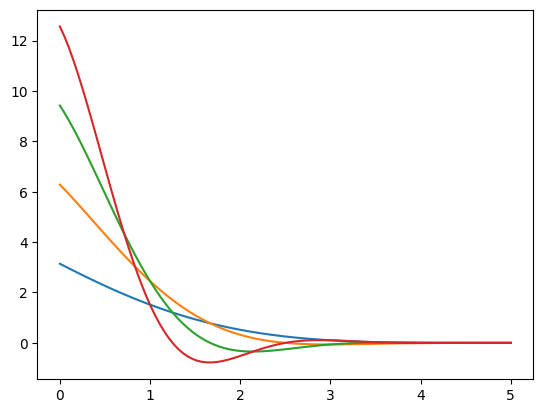

In [21]:
import seaborn as sns
from matplotlib import pyplot as plt
for i in range(n):
    plt.plot(dist_list, rbf_list[:,i])
plt.show()

# SBF

In [581]:
import numpy as np
n = 3 # number of 주양자수
l = 10 # number of angular part 궤도 양자수 l
sbf_f = SphericalBasisLayer(num_spherical=l, num_radial=n, cutoff=5.0, envelope_exponent=5)

In [582]:
def get_sbf_val(dist, angle):
    dist = torch.tensor([dist])
    angle = torch.tensor([angle])
    idx_kj = torch.tensor([0])
    sbf = sbf_f(dist, angle, idx_kj)
    sbf = sbf.tolist()[0]
    return sbf

In [583]:
max_dist=5
num_dist=10

dist_range = np.linspace(1, max_dist, num_dist)
angle_list = np.linspace(0.00001, 6.28319, 360)
total_data=[]
for d in dist_range:
    total_data_angle=[]
    for angle in angle_list:
        sbf = get_sbf_val(d, angle)
        x = d*np.cos(angle)
        y = d*np.sin(angle)
        point_data = []
        for i in sbf:
            point_data.append([x, y, i])
        total_data_angle.append(point_data)
    total_data.append(total_data_angle)
    
total_data = torch.tensor(total_data)
total_data = torch.transpose(torch.transpose(total_data, 2, 1),1,0)
total_data = total_data.view(n*l, 360*num_dist, 3)

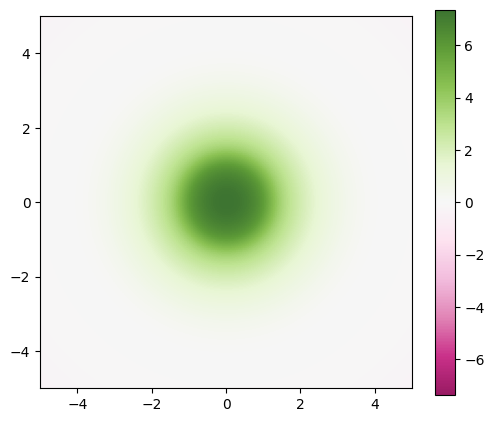

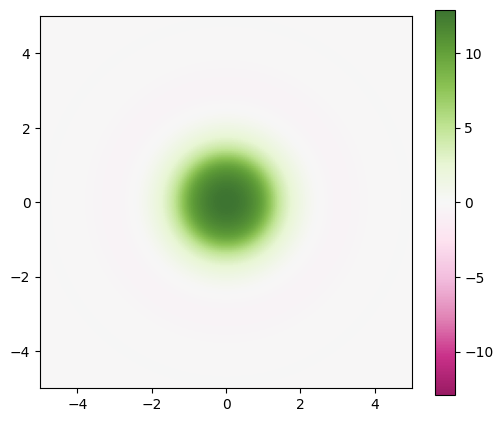

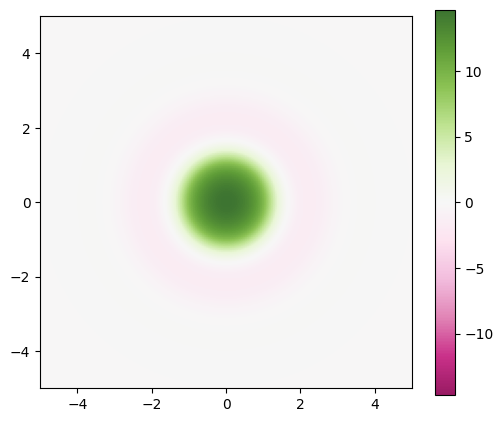

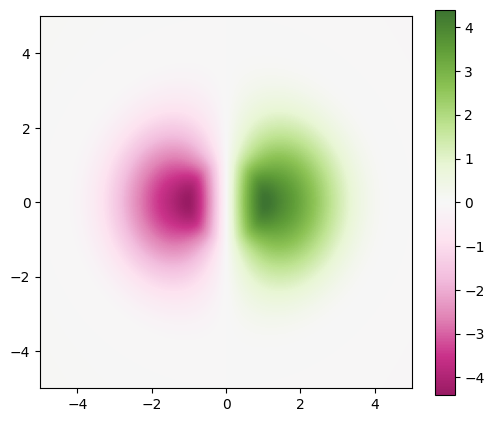

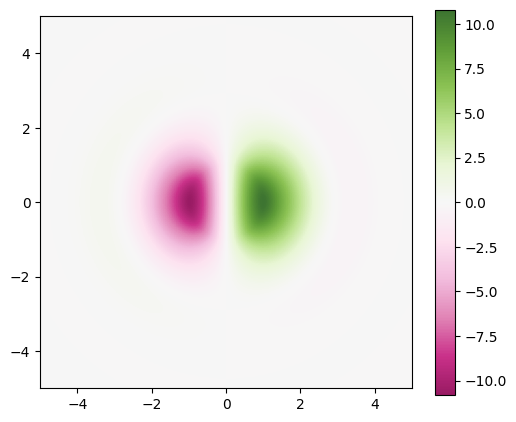

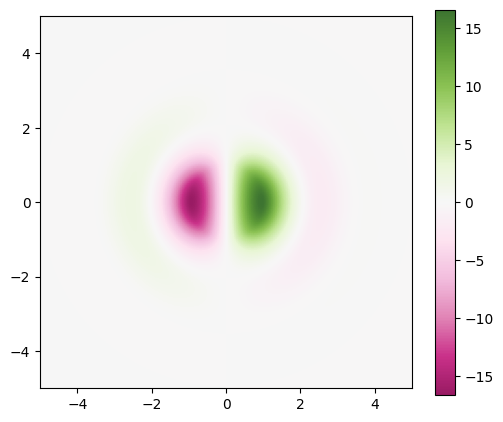

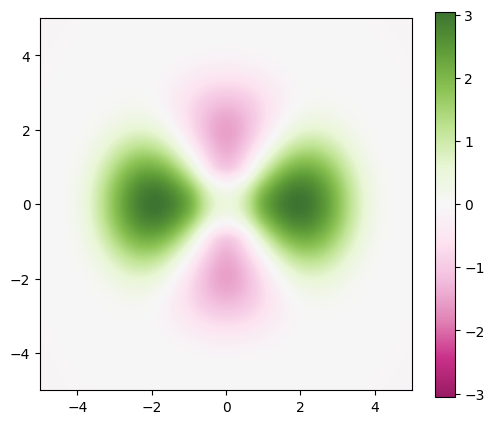

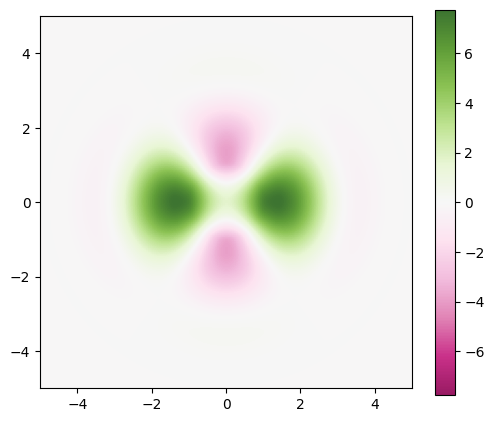

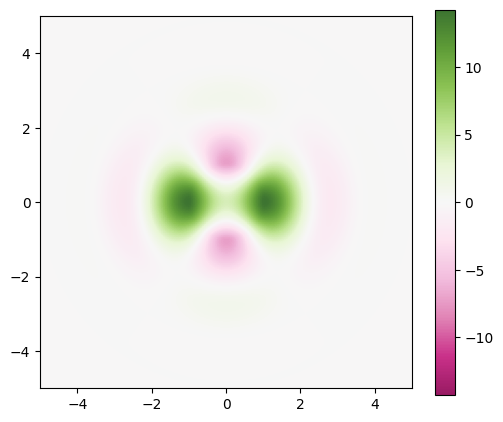

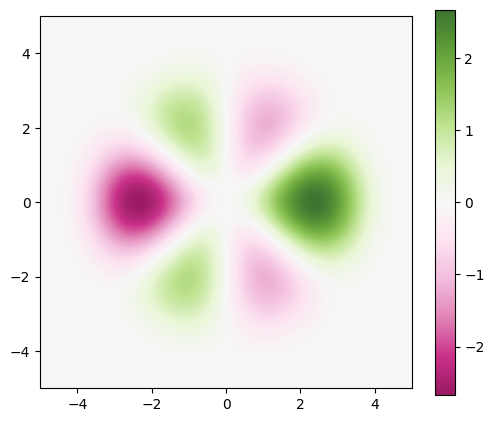

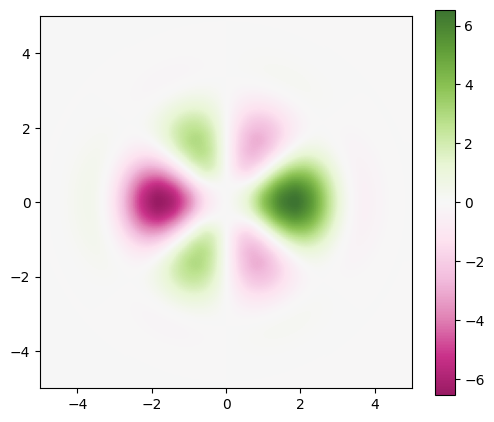

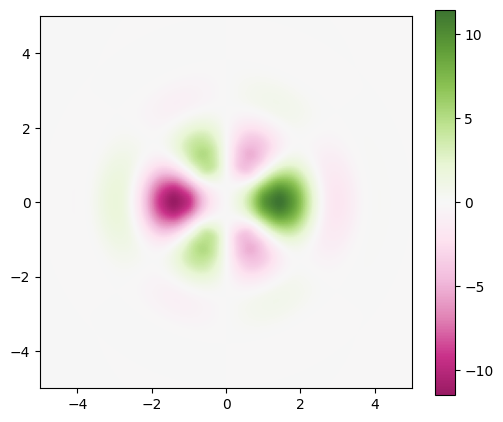

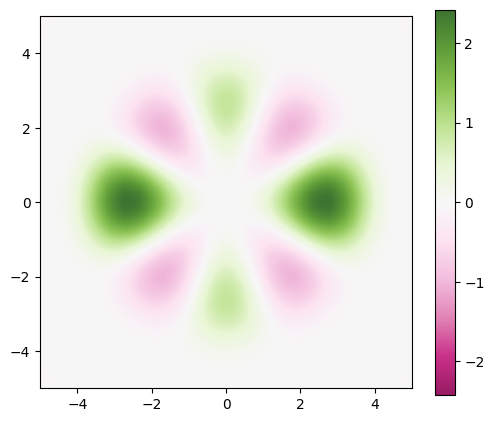

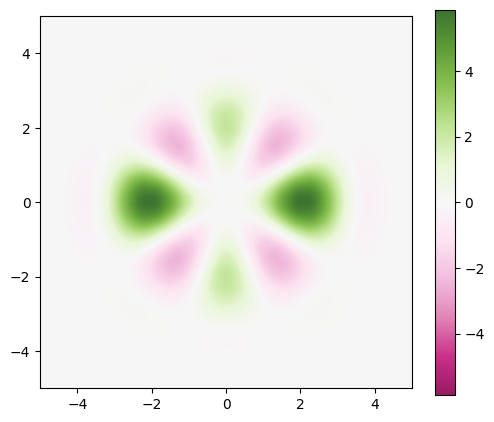

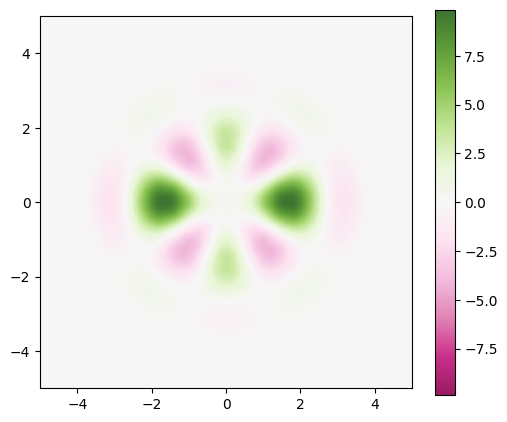

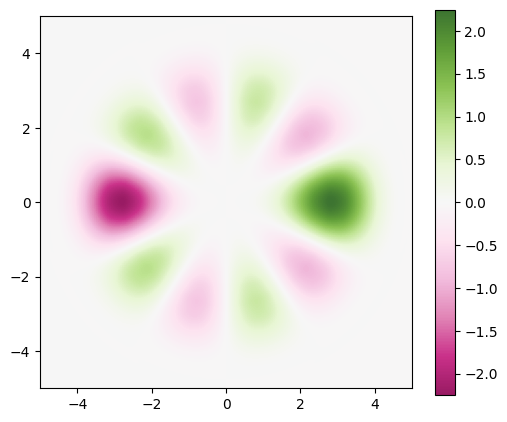

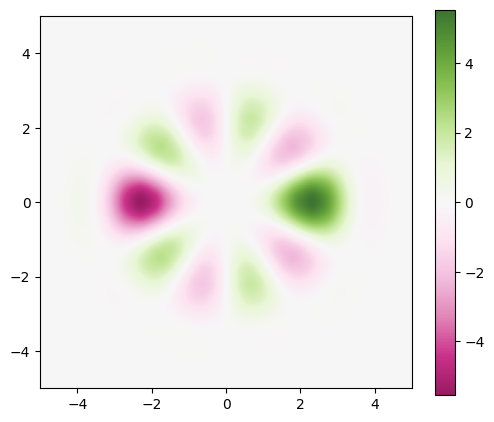

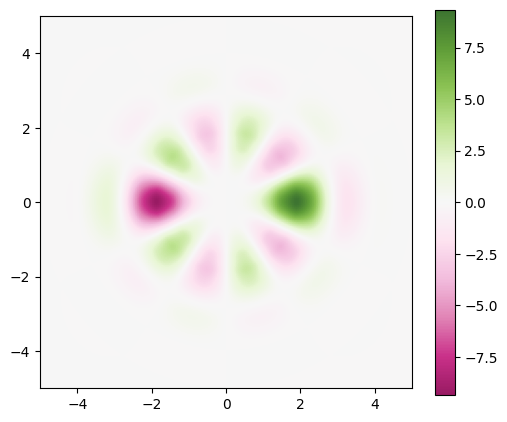

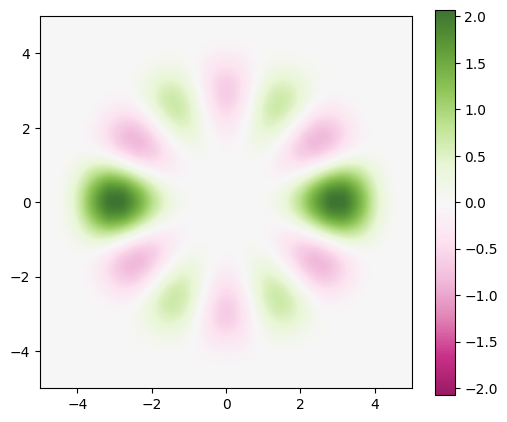

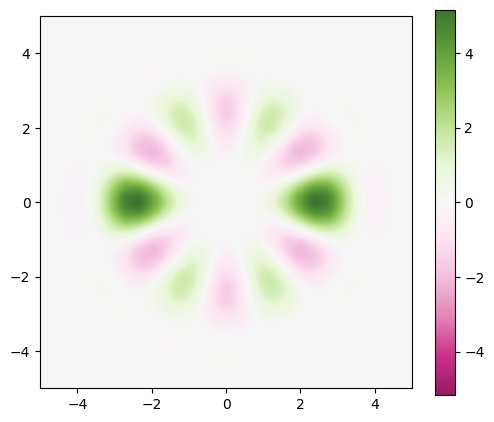

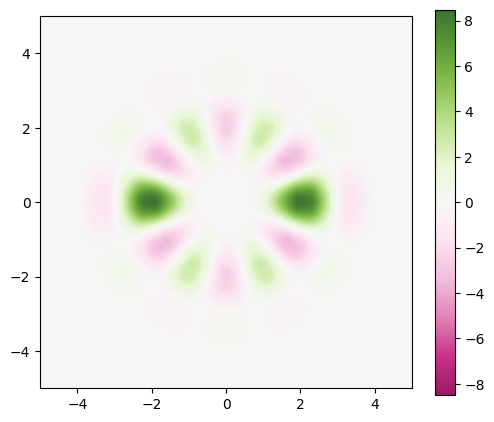

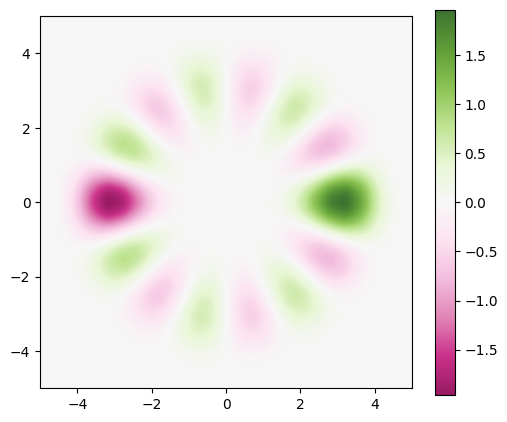

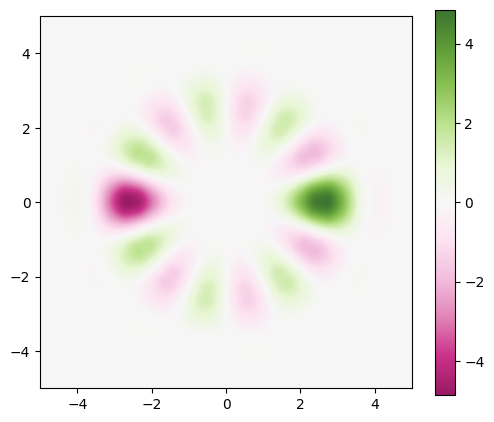

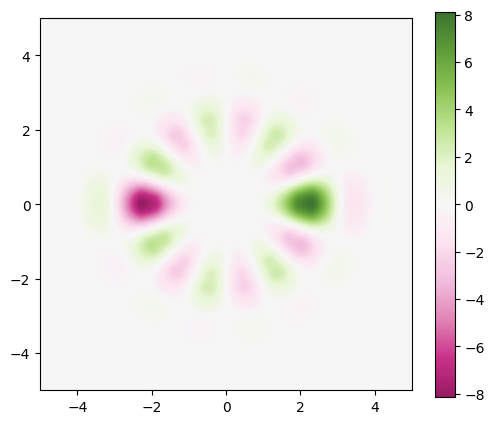

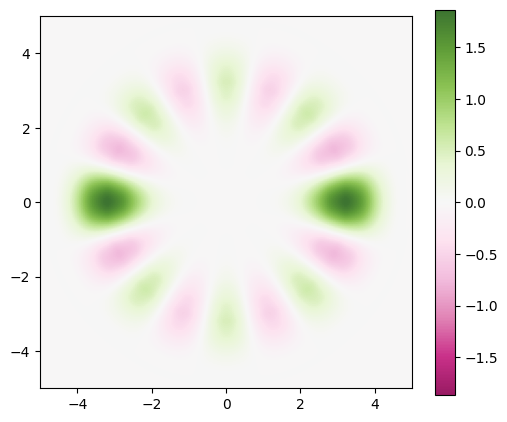

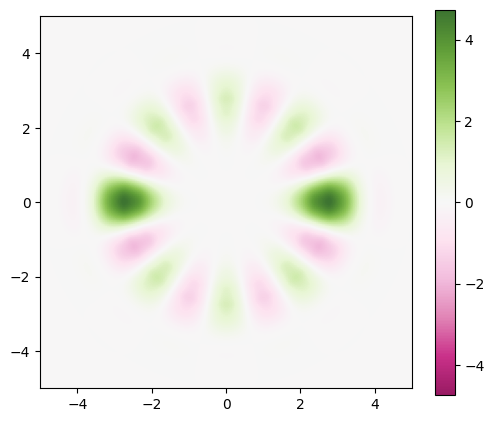

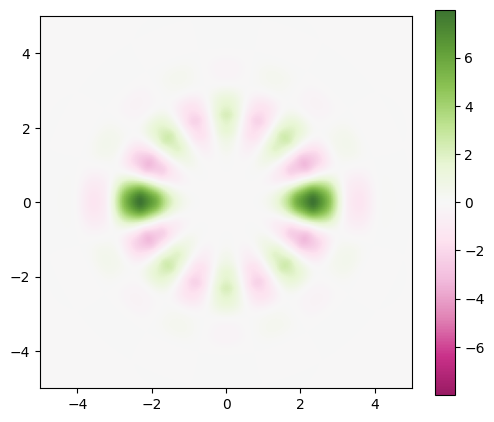

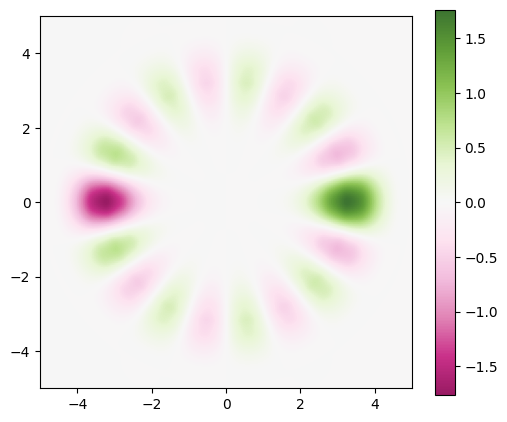

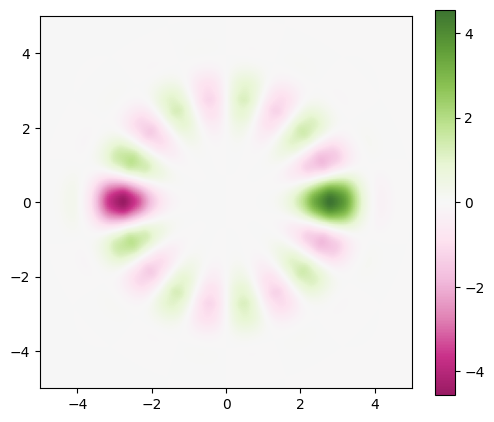

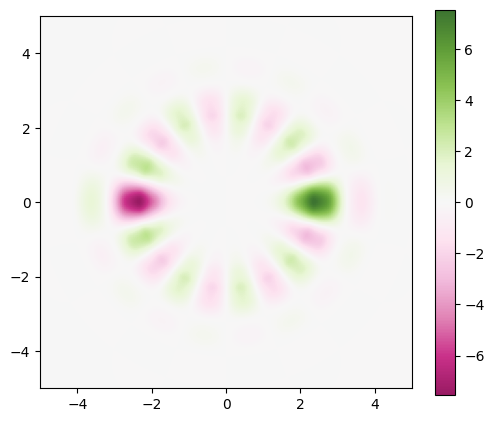

In [584]:
import matplotlib.colors as colors


for n in range(n*l):
    x_list = total_data[n,:,0].tolist()
    y_list = total_data[n,:,1].tolist()
    z_list = total_data[n,:,2].tolist()

    xi, yi = np.linspace(min(x_list), max(x_list), 200), np.linspace(min(y_list), max(y_list), 200)
    xi, yi = np.meshgrid(xi, yi)
    rbf = scipy.interpolate.Rbf(x_list, y_list, z_list, function='linear')
    zi = rbf(xi, yi)

    plt.figure(figsize=(6,5))
    #cs = plt.contourf(xi, yi, zi, 20, norm=colors.CenteredNorm(), cmap='RdGy')
    cs = plt.imshow(zi, extent=[min(x_list), max(x_list), min(y_list), max(y_list)], origin='lower', cmap='PiYG', alpha=0.9, norm=colors.CenteredNorm())
    plt.colorbar(cs)
    plt.show()